# Generic HMC 

### Imports

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import Gaussian, GMM, gen_ring
from utils.jacobian import _map, jacobian

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

tf.enable_eager_execution()
tfe = tf.contrib.eager

## 2D $U(1)$ Lattice Gauge Theory

In [85]:
time_size, space_size, dim, beta, num_samples = (16, 16, 2, 2., None)
link_type = 'U1'
lattice = GaugeLattice(time_size=time_size,
                       space_size=space_size,
                       dim=dim,
                       beta=beta,
                       link_type=link_type,
                       num_samples=num_samples, rand=True)
lattice_energy_fn = lattice.get_energy_function()

In [86]:
step_size = 0.1
n_leapfrog_steps = 25
position_init = lattice.links_flat
lattice_hmc = HMC(position_init=position_init,
                  step_size=step_size,
                  n_leapfrog_steps=n_leapfrog_steps,
                  potential_fn=lattice_energy_fn,
                  beta=lattice.beta)

In [87]:
momentum0 = np.random.randn(*lattice.links_flat.shape)
links0 = lattice.links_flat
links_arr = [links0]
vel_arr = []
probs_arr = []
avg_plaq_arr = [lattice._average_plaquette(links0)]
total_action_arr = [lattice._total_action(links0)]
links1 = links0
for i in range(500):
    links1, vel1, probs1 = lattice_hmc.apply_transition(links1)
    total_action = lattice._total_action(links1)
    avg_plaq = lattice._average_plaquette(links1)
    print(f'step: {i:<5g} accept rate: {np.mean(probs1):^8.5g}  '
          f'average_plaquette: {avg_plaq:^8.5g}  '
          f'total action: {total_action:^8.5g}  '
          f'change: {avg_plaq - avg_plaq_arr[i-1]:^8.5g}')
    avg_plaq_arr.append(avg_plaq)
    total_action_arr.append(total_action)
    if i % 50 == 0:
        links_arr.append(links1)
        vel_arr.append(vel1)
        probs_arr.append(probs1)

step: 0     accept rate:    1      average_plaquette: 0.33197   total action:  342.03   change: 0.25519 
step: 1     accept rate:    1      average_plaquette: 0.45807   total action:  277.47   change: 0.38129 
step: 2     accept rate:    1      average_plaquette: 0.58684   total action:  211.54   change: 0.25487 
step: 3     accept rate:    1      average_plaquette: 0.61837   total action:  195.39   change:  0.1603 
step: 4     accept rate:    1      average_plaquette: 0.68354   total action:  162.03   change: 0.096692
step: 5     accept rate:    1      average_plaquette: 0.70562   total action:  150.72   change: 0.087248
step: 6     accept rate: 0.83796   average_plaquette: 0.70562   total action:  150.72   change: 0.022084
step: 7     accept rate: 0.88795   average_plaquette: 0.68145   total action:  163.1    change: -0.024168
step: 8     accept rate: 0.92276   average_plaquette: 0.67028   total action:  168.82   change: -0.035338
step: 9     accept rate:    1      average_plaquette:

KeyboardInterrupt: 

In [52]:
vel_arr = np.array([i.numpy() for i in vel_arr])
probs_arr = np.array(probs_arr)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [9]:
avg_plaquettes = [lattice._average_plaquette(config) for config in links_arr]

In [11]:
np.mean(avg_plaquettes[:75])

0.4627568

In [88]:
u1_plaq_exact(5.)

Using TensorFlow backend.
[autoreload of l2hmc_eager.neural_nets failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 288, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a co

0.8933831370440852

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [16]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [18]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [19]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [11]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

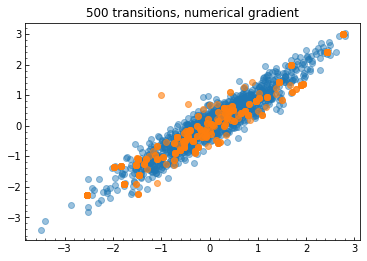

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [12]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

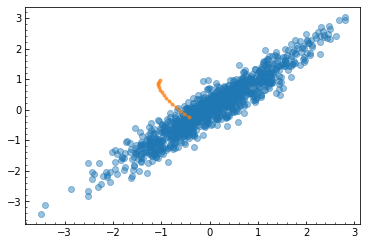

In [14]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

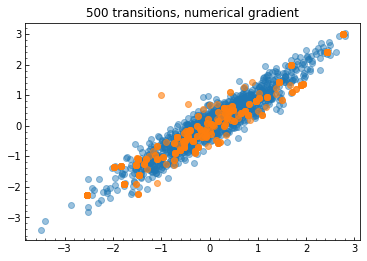

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()